# Practical Statistics for Data Scientists (Python)
# Chapter 3. Statistial Experiments and Significance Testing
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [ ]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [ ]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [ ]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

# Classical Statistical Inference Pipeline
1. Formulate hypothesis (treatment A is better than existing treatment)
2. Design experiment (A/B test)
3. Collect data 
4. Inference/Conclusion

# A/B Testing

Two groups with two different treatments, products, or procedures.

- Treatment group
- Control group

# Hypothesis Testing

- Null Hypothesis: No difference b/t A and B; A <= B; A is not X% greater than B
- Alternative Hypothesis: A is different from B; A > B; A is X% greater than B

- Most of time we conduct two-way (two-tail) hypothesis test 

# Resampling

- Bootstrap: assess the reliability of an estimate
- Permutation: test hypothesis involving two or more groups


## Premutation test
Involve two or more samples

1. Combine the results from different groups
2. Randomly draw and resample w/o replacement from the combined data to the same size as group A
3. Repeat the above step but for group B
4. Calculate the statistic for the resample groups and record it. This is one permutation iteration
5. Repeat the previous steps R times to yeild a permutation distribution

Compare the observed difference between groups and permuted differences:
- If the observed difference is within the set of permuted difference, it means nothing
- If the observed difference is not within the set of permuted difference, the difference is statistically significant


In [ ]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

session_times.head(5)

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


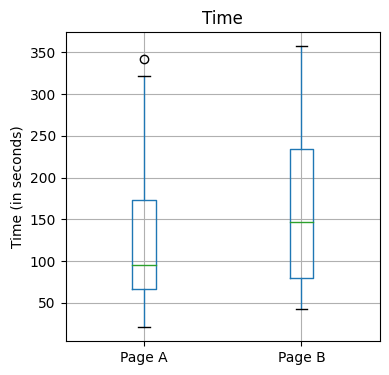

In [ ]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [ ]:
# observed difference
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


The following code is different to the R version. idx_A and idx_B are reversed.

In [ ]:
# Permutation test example with stickiness
# permuted difference 
def perm_fun(x, nA, nB):
    "x: original dataframe"
    "nA: sample size of group A"
    "nB: sample size of group B"
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(nA, nB)
print(perm_fun(session_times.Time, nA, nB))

21 15
9.609523809523807


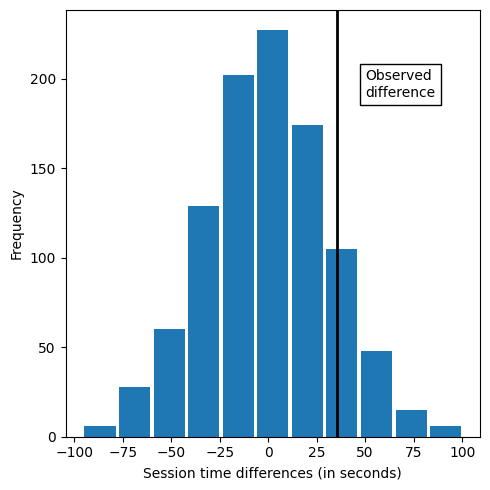

In [ ]:
# draw the histogram of all 1000 premuted resampled mean differences 
# add a line of observed mean difference from original data
# next setp is to see if this line fall into the 95% of histogram
# if yes, the difference is not statistically significant. Otherwise, it is.
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


# Statistical Significance and P-Values

## Statistical Significance
If the result is beyond the realm of chance variation, it is said to be statistically significant.


Observed difference: 0.0368%


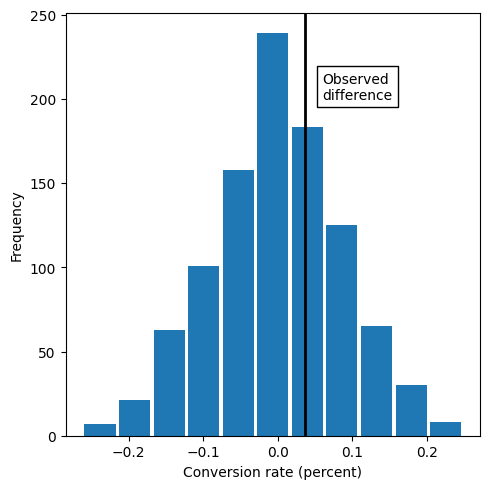

In [ ]:
random.seed(1)
# the observed difference
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')

# convert to cards of 1s and 0s
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

# create 1000 difference through the loop
perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

# draw the histogram of perm_diffs
# draw the observed difference
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## P-Value
If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).
How many perm_diff in perm_diffs array is greater than the observed difference

- If p-value is small, then it means the tail beyond the test statistic of observed value is small and far away from the null hypothesis. The result supports the alternative hypothesis more than the null hypothesis
- In general, if p-value is less than 5% (known as **Alpha**), it is considered as statistically significant and we will reject the null hypothesis

In [ ]:
# the p-value is 0.332 and is greater than 5%. 
# We cannot reject the null hypothesis and the difference is not statistically significant
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [ ]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


# Type 1 and Type 2 Errors

- Type 1 Error: mistakenly conclude an effect is real while it is really due to chance
- Type 2 Error: mistakenly conclude an effect is not real (due to chance) but it is actually real

# t-Tests

Steps:
0. Decide Null Hypothesis
1. Calculate t-statistic
$t=\frac{\bar X_1 - \bar X_2}{s_{x_1x_2}\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}$
Where 
$s_{x_1x_2}=\sqrt{\frac {(n_1-1)s^2_{X_1}+(n_2-1)s^2_{X_2}}{n_1+n_2-2}}$
2. Calculate DOF = n1+n2-2
3. Decide Alpha
4. If abs(t-stat) > alpha: statistically significant; otherwise, no statistically significant


Reference: 
- https://zh.surveymonkey.com/mp/t-tests-explained/
- https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf
- https://highscope.ch.ntu.edu.tw/wordpress/?p=70353

In [ ]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(res)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

Ttest_indResult(statistic=-1.098315562363811, pvalue=0.2815243724570064)
p-value for single sided test: 0.1408


In [ ]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(tstat)
print(df)
print(f'p-value: {pvalue:.4f}')

-1.098315562363811
27.693370059531322
p-value: 0.1408


Different tests (permuted resampling, t-test) generate different p-values but those are similar to each other. The results show that the difference are not statistically significant.

# ANOVA

- To compare multiple groups with numeric data, we use Analysis of Variance or ANOVA


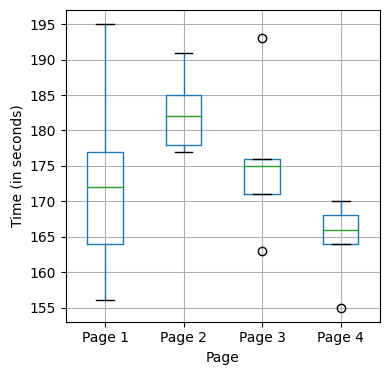

In [ ]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

## ANOVA Procedure
Example: Examine the variance among A/B/C/D groups. The following procedure can be seen as a resampling procedure


1. combine all the data together
2. randomly draw the out four resamples 
3. record the mean of each of the four groups
4. record the variance among the four group means
5. Repeat steps 2 -4 1000 times
5. Calculate the p-value: the proportion of time the resampled variance exceed the observed variance

This is a "one-way" ANOVA as there is only one factor varying (group)




In [ ]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [ ]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Observed variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    # np.random.permutation is to randomly permute a sequence
    # dataframe[<col-name>].values returns np.array 
    df['Time'] = np.random.permutation(df['Time'].values)  
    return df.groupby('Page').mean().var()[0]
    
print('one-time perm_test variance of means:', perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Observed variance: 55.426666666666655
one-time perm_test variance of means: 39.47999999999999


Pr(Prob) 0.076


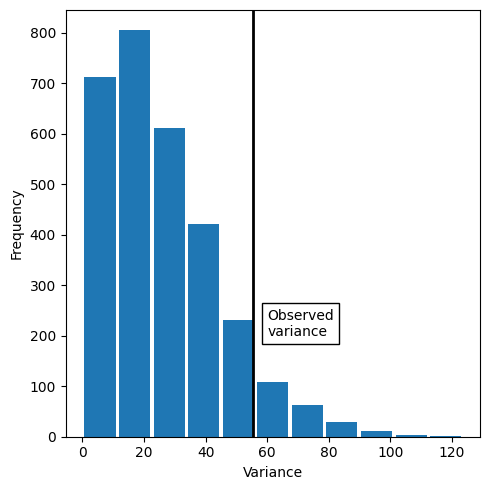

In [ ]:
random.seed(1)
# repeat resampling the variance of means 3000 times
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-Statistic
- Using statsmodel to do ANOVA based on the F-Statistic
- The F-statistic is based on the ratio of (the variance across group means) to (the variance due to residual error)
- The higher the ratio, the more statistically significant the result

### ANOVA
**Assumption**
1. Variance of each group are the same ($$s^2=\frac {\sum {(x_i-\bar x)^2}}{n-1}$$)
2. Each group are normally distributed
3. Each sample are randomly drawn


Goal: Examine the mean difference among different groups
Null hypothesis: The mean in differnt groups are the same

**Two important terms**
- Sum of Square Between = $$SS_B=\sum_{Group}{n_{group \space size}\times (\bar X_{group} - \bar X_{total})^2}$$
- Sum of Square Within = $$SS_W=\sum_{allgroup}\sum_{allgroupsample}({X_{gi}-\bar X_{group}})^2$$
- Mean Square Between = $$MS_B=SS_B/df_B$$ 
- Mean Square Within = $$MS_W=SS_W/df_W$$
- $$df_B=group \space number-1$$ 
- $$df_W=(total \space sample \space size -1)-(group \space number-1)$$ 

Alternative Hypothesis: The difference of mean among group are significant

In order to reject Null, we want large value of MSB/MSW, which is F-stat

Ref: 
1. https://zhuanlan.zhihu.com/p/57896471
2. https://belleaya.pixnet.net/blog/post/30754486-%5B%E6%95%99%E5%AD%B8%5D-%5B%E7%B5%B1%E8%A8%88%5D-anova%E8%AE%8A%E7%95%B0%E6%95%B8%E5%88%86%E6%9E%90-%E5%B0%8F%E7%AD%86%E8%A8%98




In [ ]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
# F = mean squared deviation of page / mean squared deviation of residual                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [ ]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


### Two-way anova only available with statsmodels

- There are two factors varying (supp and dose)
- Add an interaction factor: supp and dose

```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

# Chi-Square Test

- Chi-Square test is used with count data to test how well it fits some expected distribution
- Most commonly used in row by column contingency tables
- Goal: examine the each cell is independent


- Use example in reference 
Reference:
- https://belleaya.pixnet.net/blog/post/30844198
- http://www.math.nsysu.edu.tw/~lomn/homepage/R/R_testing.htm


## Chi-Square Test: A Resampling Approach

In [ ]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


11.333 is calculated as followed:
1. sum up the counts along row and colume
    a. along row: 34, 2966
    b. along column: 1000, 1000, 1000
2. the expected value for each cell is calcualted as 
    a. The expected pct. in (Headline A, Click) cell is 34/3000*1000/3000 
    b. The expected value is calculated as expected pct. times the total counts = 34/3000*1000/3000*3000 = 11.333

How to calculate chi-square value and its p-value?
1. $$\chi^2=\sum{\frac{(observed_i-expected_i)^2}{expected_i}}$$
2. once we have chi-square value and DF ((row-1)*(col-1)), we can use table to check its p-value


reference:
https://people.richland.edu/james/lecture/m170/tbl-chi.html


In [ ]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [ ]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

print(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    # random draw the sample from box and sum up the 1s, which is click
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    # 1000 - sum of clicks is the number of noclicks
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:

chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


## Figure chi-sq distribution

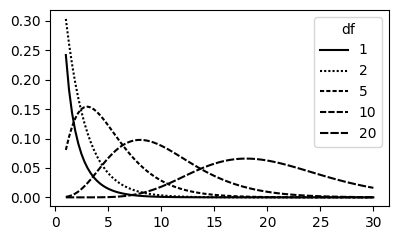

In [ ]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

## Fisher's Exact Test
Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

In [ ]:
# stats.fisher_exact(clicks.values)

### Scientific Fraud

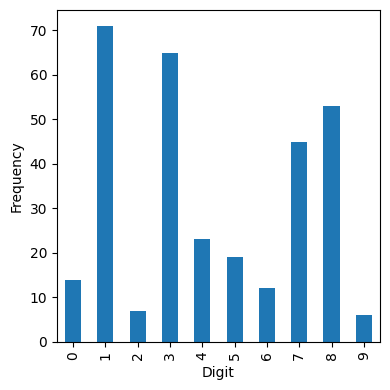

In [ ]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Power and Sample Size


- **Effect size**: the minimum size of the effect taht we hope to detect in a statistical test, like a 20% imporvement in click rates
- **Power**: the probability of detecting a given effect size with a given sample size
**detecting** means a hypothesis test will reject null hypothesis if no difference and conclude there is a real effect


statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

Mostly we want to calculate the required sample size to detect the effect size with a power.

Four elements to caluclate power or required sample size:

1. sample size
2. effect size
3. significant level (alpha)
4. power

Example 1: Calcualte the required sample size to detect the effect size of imporvement from 1.1% to 1.21% with power of 80%, the sample size of 116602 is required.

Example 2: If the power stays the same, the effect size of imporvement from 1.1% to 1.65%, the sample size of 5488 is required.


In [1]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
print(effect_size)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

0.01029785095103608
Sample Size: 116602.393


In [2]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cb61b3b3-7ab4-4e7c-a750-b396f9ef6b6f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>